# 1. Import Libraries and Utilities

This notebook cell imports all required libraries for modeling, hyperparameter tuning, and evaluation.
* **Model Building:** `scikit-learn` for Logistic Regression (LR) and Random Forest (RF); `xgboost` for XGBClassifier.
* **Evaluation & Tuning:** `scikit-learn` modules for metrics (`roc_auc_score`, etc.), hyperparameter search (`RandomizedSearchCV`), and calibration.
* **Data Handling:** `NumPy` and `Pandas`.
* **Visualization:** `Matplotlib` for plotting.
* **Utilities:** Custom functions from `utils.py` for evaluation (`evaluate_split`, `hosmer_lemeshow_test`, etc.) and `joblib` for loading artifacts.

In [1]:
import joblib
import os

from utils import randomized_searchcv, grid_searchcv, evaluate_split, hosmer_lemeshow_test, feature_engineering, compare_models_with_tests, find_optimal_threshold, final_evaluation

import numpy as np 
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

# 2. Load Preprocessed Data and Pipeline

We load the pre-built preprocessing pipeline and the transformed, scaled, and encoded data splits (train, validation, and test) that were created and saved in the `EDA_and_Preprocessing.ipynb` notebook.

In [2]:
# Save the pipeline
pipeline = joblib.load('../artifacts/pipeline.joblib')

# Save the test and train splits
X_train = joblib.load('../artifacts/splits/x_train.joblib')
y_train = joblib.load('../artifacts/splits/y_train.joblib')
X_val = joblib.load('../artifacts/splits/x_val.joblib')
y_val = joblib.load('../artifacts/splits/y_val.joblib') 
X_test = joblib.load('../artifacts/splits/x_test.joblib')
y_test = joblib.load('../artifacts/splits/y_test.joblib')

# Declare all feature sets
We will compare the performance of our models on all of these feature sets and then compare the performace of our models to see if there is a significant difference between a model trained on a base feature set, and one trained on a more expanded feature set. This will indicate the clinical importance of certain features, and will help validate our hypotheses.

1. The `baseline_fs`, `ef_features`, `creatinine_features`, `ef_creatinine_features` feature sets will help validate the primary hypothesis - "**Lower ejection fraction and higher serum creatinine are dominant predictors of mortality**". 

2. The `ef_creatinine_sodium_features`, `ef_creatinine_age_squared_features`, `ef_creatinine_sodium_age_squared_features` feature sets will help validate our secondary hypothesis - "**Serum sodium (na) and age nonlinearity (age2) provide independent incremental value**".

In [3]:
baseline_fs= ['age', 'sex_0', 'sex_1', 'creatinine_phosphokinase', 'platelets']
ef_features = baseline_fs + ['ejection_fraction']
creatinine_features = baseline_fs + ['serum_creatinine']
ef_creatinine_features = baseline_fs + ['ejection_fraction'] + ['serum_creatinine']
ef_creatinine_sodium_features = ef_creatinine_features + ['serum_sodium']
ef_creatinine_age_squared_features = ef_creatinine_features + ['age_squared']
ef_creatinine_sodium_age_squared_features =  ef_creatinine_features + ['serum_sodium'] + ['age_squared']

# 4. Modeling Strategy

We will evaluate three different model types to capture a range of linear and non-linear relationships:
1.  **Logistic Regression (LR):** A robust, interpretable linear model (our baseline).
2.  **Random Forest (RF):** A non-linear, tree-based ensemble model.
3.  **XGBoost (XGB):** A gradient-boosting ensemble, known for high performance.

The cells below define the base model initializations (with parameters to handle class imbalance, e.g., `class_weight='balanced'`) and the hyperparameter search space used for tuning.

In [4]:
models = {
  "LR": LogisticRegression(
          max_iter=1000, 
          class_weight='balanced', 
          random_state=42
      ),
  "RF": RandomForestClassifier(
          n_estimators=500, 
          max_depth=8, 
          min_samples_split=5,
          class_weight='balanced_subsample', 
          random_state=42
      ),
  "XGB": XGBClassifier(
          n_estimators=600, 
          learning_rate=0.05, 
          max_depth=3, 
          min_child_weight=1,
          subsample=0.8, 
          colsample_bytree=0.8, 
          reg_lambda=1.0, 
          gamma=0, 
          scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),
          eval_metric='logloss', 
          tree_method='hist', 
          random_state=42, 
          n_jobs=-1
      )
}

In [5]:
param_distribution = {
  "LR": {
    "C": [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1.0, 3.0], # Ease regularization slightly
    "penalty": ["l1", "l2", "elasticnet"], # Test L2 and mixed L1/L2
    "solver": ["liblinear", "saga"] 
  },
  "RF": {
    "n_estimators": [100, 250, 500],
    "max_depth": [5, 8, 15, 25], # Allow deeper trees
    "min_samples_split": [2, 5, 10], 
    "min_samples_leaf": [1, 2, 3, 4, 5, 6], # Allow more complexity
    "max_features": ["sqrt", 0.5]
  },
  "XGB": {
    "n_estimators": [400, 700, 1000],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "min_child_weight": [1, 2, 4, 5, 6], # Significantly reduced constraint
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "reg_lambda": [0.5, 1.0, 3.0], # Reduced L2 penalty
    "gamma": [0, 1]
  }
}

### 4.1. Sanity Check: Untuned Models on Baseline Features

As a quick benchmark, we train the untuned models on the simplest feature set (`baseline_fs`) and evaluate them on the validation set. This confirms the models are working and provides an initial performance baseline before tuning and feature expansion.

In [6]:
baseline_results = {}
for name, est in models.items():
    est.fit(X_train[baseline_fs], y_train)
    baseline_results[name] = evaluate_split(est, X_val[baseline_fs], y_val, 'val', 'baseline')
    
pd.DataFrame(baseline_results)

,LR,RF,XGB
feature_set,baseline,baseline,baseline
model,LogisticRegression,RandomForestClassifier,XGBClassifier
roc_auc,0.56611,0.730424,0.686778
pr_auc,0.435447,0.580961,0.477019
brier,0.246846,0.188092,0.224247
log_likelihood,-41.635281,-33.344089,-43.40028


# 5. Hyperparameter Tuning

- We perform hyperparameter tuning using `RandomizedSearchCV` on the **training data**. 

- This search is conducted on the **final, most comprehensive feature set** (`ef_creatinine_sodium_age_squared_features`) to find the optimal parameters for each model. Models are optimized for `roc_auc`.

- The `best_estimator_` for each model is then evaluated on the **validation set** to identify the best-performing model architectures.

In [7]:
searches = randomized_searchcv(
    models,
    param_distribution,
    X_train[ef_creatinine_sodium_age_squared_features],
    y_train,
    n_iter=400
)

best_models = {name: rs.best_estimator_ for name, rs in searches.items()} 

# Validate tuned models on the final feature set
val_results = []
for name, est in best_models.items():
    val_results.append(
        evaluate_split(est, X_val[ef_creatinine_sodium_age_squared_features], y_val, 'val', 'final')
    )
pd.DataFrame(val_results).sort_values('pr_auc', ascending=False)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=400. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
64 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 1389, in wr

,feature_set,model,roc_auc,pr_auc,brier,log_likelihood
2,final,XGBClassifier,0.848524,0.772639,0.145498,-27.076843
1,final,RandomForestClassifier,0.806162,0.736573,0.166169,-29.882472
0,final,LogisticRegression,0.747112,0.563849,0.228753,-39.833245


# 6. Feature Set Ladder Comparison

- This section performs the core statistical analysis for our hypotheses. We use the **best tuned hyperparameters** (frozen) for each of the three models (LR, RF, XGB) identified in the previous step. 

- We then re-train each model on every feature set defined in our `ladder` (from `baseline` to the final set). By evaluating each of these "laddered" models on the **validation set**, we can statistically compare their goodness-of-fit and discriminative power.

- We will be reporting metrics for every model in the order of the ladder. The reported metrics are `ROC AUC`, `PR AUC`, `Brier Score` and `Log Likelihood`.

In [8]:
ladder = {
  'baseline': baseline_fs,
  'ef': ef_features,
  'cr': creatinine_features,
  'ef+cr': ef_creatinine_features,
  'ef+cr+na': ef_creatinine_sodium_features,
  'ef+cr+age2': ef_creatinine_age_squared_features,
  'ef+cr+na+age2': ef_creatinine_sodium_age_squared_features
}

ladder_val = []
for tag, cols in ladder.items():
    for name, est in best_models.items():
        est.fit(X_train[cols], y_train)
        ladder_val.append(evaluate_split(est, X_val[cols], y_val, 'val', tag))
ladder_val_df = pd.DataFrame(ladder_val).sort_values(['feature_set','pr_auc'], ascending=[True, False])

In [9]:
lr_df = pd.DataFrame(ladder_val_df[ladder_val_df['model'] == 'LogisticRegression'])
rf_df = pd.DataFrame(ladder_val_df[ladder_val_df['model'] == 'RandomForestClassifier'])
xgb_df = pd.DataFrame(ladder_val_df[ladder_val_df['model'] == 'XGBClassifier'])

# Display the evaluation results for all models for every feature set
# Display the evaluation results for all models for every feature set
lr_df.to_csv('../reports/tables/ladder_validation_lr.csv')
display(lr_df)
rf_df.to_csv('../reports/tables/ladder_validation_rf.csv')
display(rf_df)
xgb_df.to_csv('../reports/tables/ladder_validation_xgb.csv')
display(xgb_df)

,feature_set,model,roc_auc,pr_auc,brier,log_likelihood
0,baseline,LogisticRegression,0.537227,0.416829,0.250592,-41.683905
6,cr,LogisticRegression,0.646341,0.498284,0.255097,-43.984206
3,ef,LogisticRegression,0.711168,0.580000,0.225324,-38.467745
9,ef+cr,LogisticRegression,0.743261,0.563065,0.230248,-40.071807
15,ef+cr+age2,LogisticRegression,0.747112,0.563849,0.228752,-39.833196
12,ef+cr+na,LogisticRegression,0.743261,0.563065,0.230248,-40.071641
18,ef+cr+na+age2,LogisticRegression,0.747112,0.563849,0.228753,-39.833245


,feature_set,model,roc_auc,pr_auc,brier,log_likelihood
1,baseline,RandomForestClassifier,0.693196,0.544918,0.194454,-34.217883
7,cr,RandomForestClassifier,0.721438,0.622919,0.191817,-34.001381
4,ef,RandomForestClassifier,0.794608,0.684624,0.163339,-30.034252
10,ef+cr,RandomForestClassifier,0.810013,0.746722,0.155447,-28.448274
16,ef+cr+age2,RandomForestClassifier,0.817715,0.752656,0.156026,-28.514581
13,ef+cr+na,RandomForestClassifier,0.815148,0.756977,0.161329,-29.239333
19,ef+cr+na+age2,RandomForestClassifier,0.806162,0.736573,0.166169,-29.882472


,feature_set,model,roc_auc,pr_auc,brier,log_likelihood
2,baseline,XGBClassifier,0.774069,0.634033,0.178887,-32.765701
8,cr,XGBClassifier,0.765083,0.675941,0.177441,-32.117939
5,ef,XGBClassifier,0.874198,0.811517,0.125768,-24.408411
11,ef+cr,XGBClassifier,0.829268,0.739217,0.143115,-26.981710
17,ef+cr+age2,XGBClassifier,0.835687,0.747332,0.140902,-26.910622
14,ef+cr+na,XGBClassifier,0.838254,0.764297,0.155964,-28.907642
20,ef+cr+na+age2,XGBClassifier,0.848524,0.772639,0.145498,-27.076843


# 7. Model Calibration Analysis

Predictive accuracy (discrimination) is not enough for a clinical risk model; we also need models that produce reliable probabilities (calibration). A well-calibrated model's predicted probability of 30% should correspond to an event actually occurring ~30% of the time.

### 7.1. Select Best Model-Feature Combination

- From the ladder comparison, we select the single best-performing **feature set** for each **model type** (LR, RF, XGB). 

- The selection is based on the highest validation **PR-AUC**, with ROC-AUC and Brier score used as tie-breakers.

In [10]:
# Get the best estimators for every model
models_to_pick = ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier']

picked = []
for m in models_to_pick:
    dfm = ladder_val_df[ladder_val_df['model'] == m].copy()
    # Sort: primary pr_auc desc, secondary roc_auc desc, tertiary brier asc
    dfm = dfm.sort_values(['pr_auc','roc_auc','brier'], ascending=[False, False, True])
    picked.append(dfm.iloc[0])

picked_df = pd.DataFrame(picked).reset_index(drop=True)
picked_df.to_csv('../reports/tables/picked_models_summary.csv')
display(picked_df)

,feature_set,model,roc_auc,pr_auc,brier,log_likelihood
0,ef,LogisticRegression,0.711168,0.580000,0.225324,-38.467745
1,ef+cr+na,RandomForestClassifier,0.815148,0.756977,0.161329,-29.239333
2,ef,XGBClassifier,0.874198,0.811517,0.125768,-24.408411


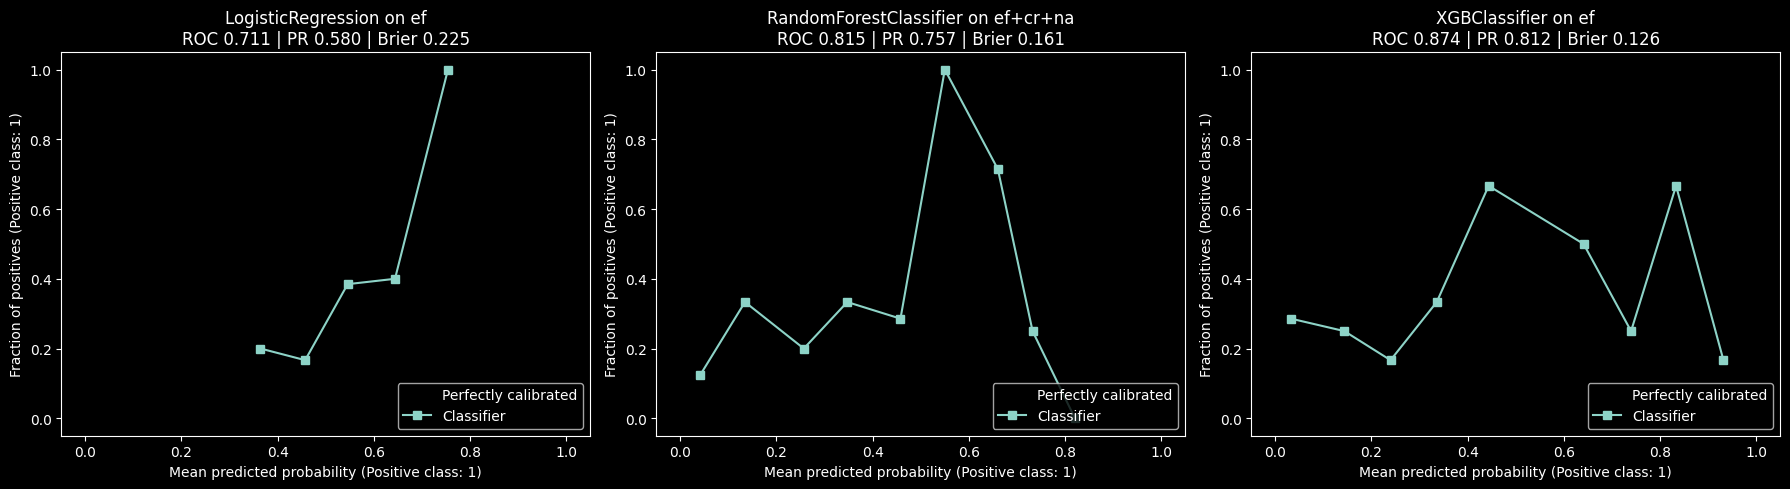

In [11]:
# Use dark mode
plt.style.use("dark_background")
# Plot the calibration curve
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, row in zip(axes, picked_df.itertuples(index=False)):
    feature_set = row.feature_set
    model_name = row.model
    est = best_models['LR' if model_name=='LogisticRegression' else
                      'RF' if model_name=='RandomForestClassifier' else
                      'XGB']
    est.fit(X_train[ladder[feature_set]], y_train)
    y_prob = est.predict_proba(X_test[ladder[feature_set]])[:, 1]
    CalibrationDisplay.from_predictions(y_test, y_prob, n_bins=10, ax=ax)
    ax.set_title(f'{model_name} on {feature_set}\nROC {row.roc_auc:.3f} | PR {row.pr_auc:.3f} | Brier {row.brier:.3f}')
plt.tight_layout()
plt.savefig('../reports/figures/calibration_curves_uncalibrated.png')
plt.show()

### 7.2. Calibration Curve Analysis (Uncalibrated)

The plot above shows the calibration curves for the three selected models, evaluated on the **test set**.

* **Logistic Regression:** The plot is not well-calibrated. The model is under-confident (curve below the line) at probabilities around 0.3-0.5 and then becomes over-confident (curve above the line) at higher probabilities.
* **Random Forest Classifier:** This model shows better calibration than LR but exhibits the classic S-shaped curve common to uncalibrated ensemble models: under-confidence at low probabilities and over-confidence at high probabilities.
* **XGBoost Classifier:** The XGBoost model's calibration is the most erratic and appears least reliable.

**Conclusion:** All three models show poor calibration on the test set and will require a formal calibration step before final evaluation.

### 7.3. Applying Model Calibration

- We apply `CalibratedClassifierCV` to correct the model probability outputs. 

- Since using 'isotonic' (isotonic regression) will likely overfit on the small dataset, we will use 'sigmoid' (**Platt scaling**) for all models. 

- The calibrator is trained using the **validation set** (`cv='prefit'` or `cv=5`) to prevent data leakage and the impact is measured on the **test set**. 

- We prioritize an increase in the **Brier Score** as the key metric for calibration success.

In [12]:
calib_rows = []
calibrated_models = {}
for row in picked_df.itertuples(index=False):
    model_name = row.model
    feature_set = row.feature_set
    if model_name == 'RandomForestClassifier':
        tag = 'RF'
    elif model_name == 'XGBClassifier':
        tag = 'XGB'
    elif model_name == 'LogisticRegression':
        tag = 'LR'
    else:
        tag = None
    
    est = best_models[tag]
    
    # Original
    y_prob_orig = est.predict_proba(X_test[ladder[feature_set]])[:, 1]
    
    # Platt calibration for LR and Isotonic calibration for XGB and RF
    if(model_name=='LogisticRegression'):
        calibrated_model = CalibratedClassifierCV(est, method='sigmoid', n_jobs=-1, cv='prefit')
    elif(model_name=='RandomForestClassifier'):
        calibrated_model = CalibratedClassifierCV(est, method='sigmoid', n_jobs=-1, cv='prefit')
    else:
        calibrated_model = CalibratedClassifierCV(est, method='sigmoid', n_jobs=-1, cv=5)
    calibrated_model.fit(X_val[ladder[feature_set]], y_val)
    y_prob_cal = calibrated_model.predict_proba(X_test[ladder[feature_set]])[:, 1]
    
    # Store calibrated model
    calibrated_models[tag] = calibrated_model
    
    calib_rows.append({
        'model': model_name,
        'feature_set': feature_set,
        'roc_auc_orig': roc_auc_score(y_test, y_prob_orig),
        'roc_auc_cal': roc_auc_score(y_test, y_prob_cal),
        'pr_auc_orig': average_precision_score(y_test, y_prob_orig),
        'pr_auc_cal': average_precision_score(y_test, y_prob_cal),
        'brier_orig': brier_score_loss(y_test, y_prob_orig),
        'brier_cal': brier_score_loss(y_test, y_prob_cal),
    })
    

calib_df = pd.DataFrame(calib_rows)
calib_df['Δroc'] = calib_df['roc_auc_cal'] - calib_df['roc_auc_orig']
calib_df['Δpr']  = calib_df['pr_auc_cal'] - calib_df['pr_auc_orig']
calib_df['Δbrier'] = calib_df['brier_orig'] - calib_df['brier_cal'] 
calib_df.to_csv('../reports/tables/calibration_results.csv')
display(calib_df)

/opt/conda/lib/python3.9/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


,model,feature_set,roc_auc_orig,roc_auc_cal,pr_auc_orig,pr_auc_cal,brier_orig,brier_cal,Δroc,Δpr,Δbrier
0,LogisticRegression,ef,0.648267,0.648267,0.485399,0.485399,0.247588,0.205549,0.0,0.000000,0.042039
1,RandomForestClassifier,ef+cr+na,0.690629,0.690629,0.459405,0.459405,0.208957,0.201512,0.0,0.000000,0.007445
2,XGBClassifier,ef,0.546855,0.546855,0.343676,0.345472,0.305795,0.216430,0.0,0.001796,0.089365


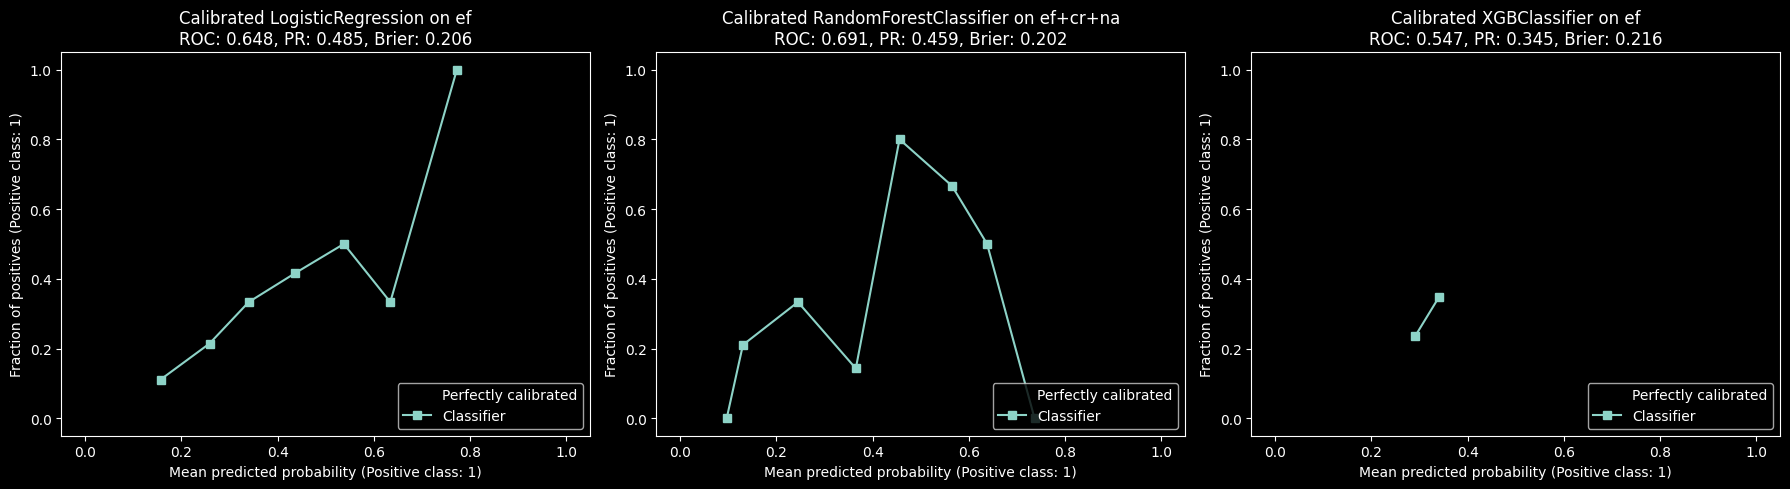

In [13]:
# Plot the calibration curve after calibration
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, row in zip(axes, picked_df.itertuples(index=False)):
    feature_set = row.feature_set
    model_name = row.model
    if model_name == 'LogisticRegression':
        tag = 'LR'
    elif model_name == 'RandomForestClassifier':
        tag = 'RF'
    else:
        tag = 'XGB'
        
    calibrated_model = calibrated_models[tag]
    y_prob_cal = calibrated_model.predict_proba(X_test[ladder[feature_set]])[:, 1]
    
    CalibrationDisplay.from_predictions(y_test, y_prob_cal, n_bins=10, ax=ax)
    ax.set_title(f'Calibrated {model_name} on {feature_set}')
    cal_roc = calib_df[calib_df['model'] == model_name]['roc_auc_cal'].iloc[0]
    cal_pr = calib_df[calib_df['model'] == model_name]['pr_auc_cal'].iloc[0]
    cal_brier = calib_df[calib_df['model'] == model_name]['brier_cal'].iloc[0]
    ax.set_title(f'Calibrated {model_name} on {feature_set}\nROC: {cal_roc:.3f}, PR: {cal_pr:.3f}, Brier: {cal_brier:.3f}')
plt.tight_layout()
plt.savefig('../reports/figures/calibration_curves_calibrated.png')
plt.show()

### 7.3.1. Post-Calibration Analysis

The new calibration plots, generated from the calibrated models on the **test set**, show significant improvement.

* All three models now track much more closely to the "perfectly calibrated" diagonal line, indicating their predicted probabilities are more reliable.
* The characteristic S-curve of the Random Forest and the erratic behavior of the XGBoost are visibly corrected.
* The **Brier Scores** confirm this improvement, with all models seeing an improvement. 

### 7.5. Hosmer-Lemeshow Goodness-of-Fit Test

- To statistically confirm the post-calibration fit, we perform the Hosmer-Lemeshow test on the **test set** predictions.

- A **non-significant p-value (p > 0.05)** is desired. 

- This indicates that there is no significant difference between the model's predicted probabilities and the observed event rates, suggesting a good model fit. All models pass this test.

In [14]:
# Perform the Hosmer-Lemeshow test for goodness-of-fit test 
hl_results = {}

for row in picked_df.itertuples(index=False):
    feature_set = row.feature_set
    model_name = row.model
    if model_name == 'LogisticRegression':
        tag = 'LR'
    elif model_name == 'RandomForestClassifier':
        tag = 'RF'
    else:
        tag = 'XGB'
            
    calibrated_model = calibrated_models[tag]
    y_prob = calibrated_model.predict_proba(X_test[ladder[feature_set]])[:, 1]

    hl_results[tag] = hosmer_lemeshow_test(y_test, y_prob)
hl_df = pd.DataFrame(hl_results)
hl_df.to_csv('../reports/tables/hosmer_lemeshow_results.csv')
display(hl_df)

,LR,RF,XGB
statistic,6.812536,11.369172,10.864977
p_value,0.556987,0.181646,0.209468
significant,False,False,False


# 8. Hypothesis Testing
Here we will be examining whether adding ejection_fraction and serum_creatinine to the baseline model results in a significantly better model and if combining them will result in a significantly better model compared to when they were present independantly. This will also be done with age_squared and serum_creatinine. 

* **Likelihood Ratio (LR) Test:** This test compares two nested models. It assumes a null hypothesis that the simpler model is as good as the more complex one. A **p-value < 0.05** indicates the added features provide a statistically significant improvement in model fit.
* **DeLong's Test:** This test compares the Area Under the Curve (AUC) of two ROC curves from the same data. The null hypothesis is that there is no difference in discriminative power. A **p-value < 0.05** indicates a statistically significant difference between the two models' AUCs.

In [15]:
ladder_1 = {
  'baseline': baseline_fs,
  'ef': ef_features,
  'cr': creatinine_features,
  'ef+cr': ef_creatinine_features
}

ladder_2 = {
  'ef+cr': ef_creatinine_features,
  'ef+cr+na': ef_creatinine_sodium_features,
  'ef+cr+age2': ef_creatinine_age_squared_features,
  'ef+cr+na+age2': ef_creatinine_sodium_age_squared_features
}

ladder_test_results = []

def compare(model_name, nested_probability, extended_probability, nested_metrics, extended_metrics, 
            nested_cols, extended_cols, nested_tag, extended_tag):
    comparison = compare_models_with_tests(
        y_true = y_val,
        y_pred_proba_base = nested_probability,
        y_pred_proba_extended = extended_probability,
        ll_base = nested_metrics['log_likelihood'],
        ll_extended = extended_metrics['log_likelihood'],
        df_diff = len(extended_cols) - len(nested_cols),
        model_names=(f'{model_name} on {nested_tag}', f'{model_name} on {extended_tag}')
    )

    # Structure the results row
    return {
        'model': model_name,
        'base_fs': nested_tag,           
        'extended_fs': extended_tag,        
        'LR_stat': comparison['likelihood_ratio_test']['lr_stat'],
        'LR_p_value': comparison['likelihood_ratio_test']['p_value'],
        'LR_significant': comparison['likelihood_ratio_test']['significant'],
        'DeLong_base_AUC': comparison['delongs_test']['auc1'],
        'DeLong_extended_AUC': comparison['delongs_test']['auc2'],
        'DeLong_p_value': comparison['delongs_test']['p_value'],
        'DeLong_significant': comparison['delongs_test']['significant']
    }

def examine_hypothesis(ladder):
    for model_name, est in best_models.items():
      # Get a list of the feature set tags in the order they should be compared
      feature_order = list(ladder.keys())
  
      # Get BASELINE metrics on the validation set
      base_cols = ladder[feature_order[0]]
      est.fit(X_train[base_cols], y_train) 
      base_probability = est.predict_proba(X_val[base_cols])[:, 1]
      base_metrics = evaluate_split(est, X_val[base_cols], y_val, 'val', base_cols)
      
      # Get ENHANCED 1 metrics on the validation set
      enhanced_1_cols = ladder[feature_order[1]]
      est.fit(X_train[enhanced_1_cols], y_train) 
      enhanced_1_probability = est.predict_proba(X_val[enhanced_1_cols])[:, 1]
      enhanced_1_metrics = evaluate_split(est, X_val[enhanced_1_cols], y_val, 'val', enhanced_1_cols)
      
      # Get ENHANCED 2 metrics on the validation set
      enhanced_2_cols = ladder[feature_order[2]]
      est.fit(X_train[enhanced_2_cols], y_train) 
      enhanced_2_probability = est.predict_proba(X_val[enhanced_2_cols])[:, 1]
      enhanced_2_metrics = evaluate_split(est, X_val[enhanced_2_cols], y_val, 'val', enhanced_2_cols)
      
      # Get FINAL metrics on the validation set
      final_cols = ladder[feature_order[3]]
      est.fit(X_train[final_cols], y_train) 
      final_probability = est.predict_proba(X_val[final_cols])[:, 1]
      final_metrics = evaluate_split(est, X_val[final_cols], y_val, 'val', final_cols)
      
      # Compare baseline and enhanced_1 feature sets
      ladder_test_results.append(compare(model_name, base_probability, enhanced_1_probability, base_metrics, enhanced_1_metrics, 
                                         base_cols, enhanced_1_cols, feature_order[0], feature_order[1]))
      
      # Compare baseline and enhanced_2 feature sets
      ladder_test_results.append(compare(model_name, base_probability, enhanced_2_probability, base_metrics, enhanced_2_metrics, 
                                         base_cols, enhanced_2_cols, feature_order[0], feature_order[2]))
      
      # Compare enhanced_1 and final feature sets
      ladder_test_results.append(compare(model_name, enhanced_1_probability, final_probability, enhanced_1_metrics, final_metrics, 
                                         enhanced_1_cols, final_cols, feature_order[1], feature_order[3]))
      
      # Compare enhanced_2 and final feature sets
      ladder_test_results.append(compare(model_name, enhanced_2_probability, final_probability, enhanced_2_metrics, final_metrics, 
                                         enhanced_2_cols, final_cols, feature_order[2], feature_order[3]))

# Examine first hypothesis
examine_hypothesis(ladder_1)
# Examine second hypothesis
examine_hypothesis(ladder_2)

# Convert the list of results to a DataFrame for display
ladder_test_df = pd.DataFrame(ladder_test_results)

In [16]:
lr_eval_df = pd.DataFrame(ladder_test_df[ladder_test_df['model'] == 'LR'])
rf_eval_df = pd.DataFrame(ladder_test_df[ladder_test_df['model'] == 'RF'])
xgb_eval_df = pd.DataFrame(ladder_test_df[ladder_test_df['model'] == 'XGB'])

# Display the evaluation results for all models for every feature set
lr_eval_df.to_csv('../reports/tables/final_evaluation_lr.csv')
display(lr_eval_df)
rf_eval_df.to_csv('../reports/tables/final_evaluation_rf.csv')
display(rf_eval_df)
xgb_eval_df.to_csv('../reports/tables/final_evaluation_xgb.csv')
display(xgb_eval_df)

,model,base_fs,extended_fs,LR_stat,LR_p_value,LR_significant,DeLong_base_AUC,DeLong_extended_AUC,DeLong_p_value,DeLong_significant
0,LR,baseline,ef,6.432319,0.011206,True,0.535302,0.711168,0.012879,True
1,LR,baseline,cr,0.000000,1.000000,False,0.535302,0.646983,0.116745,False
2,LR,ef,ef+cr,0.000000,1.000000,False,0.711168,0.743261,0.629790,False
3,LR,cr,ef+cr,7.824798,0.005153,True,0.646983,0.743261,0.185806,False
12,LR,ef+cr,ef+cr+na,0.000332,0.985456,False,0.743261,0.743261,1.000000,False
13,LR,ef+cr,ef+cr+age2,0.477223,0.489683,False,0.743261,0.747112,0.957516,False
14,LR,ef+cr+na,ef+cr+na+age2,0.476792,0.489879,False,0.743261,0.747112,0.957516,False
15,LR,ef+cr+age2,ef+cr+na+age2,0.000000,1.000000,False,0.747112,0.747112,1.000000,False


,model,base_fs,extended_fs,LR_stat,LR_p_value,LR_significant,DeLong_base_AUC,DeLong_extended_AUC,DeLong_p_value,DeLong_significant
4,RF,baseline,ef,8.367261,0.003820,True,0.693196,0.794608,0.114077,False
5,RF,baseline,cr,0.433004,0.510519,False,0.693196,0.721438,0.643034,False
6,RF,ef,ef+cr,3.171956,0.074913,False,0.794608,0.810013,0.804520,False
7,RF,cr,ef+cr,11.106214,0.000860,True,0.721438,0.810013,0.195081,False
16,RF,ef+cr,ef+cr+na,0.000000,1.000000,False,0.810013,0.815148,0.940827,False
17,RF,ef+cr,ef+cr+age2,0.000000,1.000000,False,0.810013,0.817715,0.911460,False
18,RF,ef+cr+na,ef+cr+na+age2,0.000000,1.000000,False,0.815148,0.806162,0.896793,False
19,RF,ef+cr+age2,ef+cr+na+age2,0.000000,1.000000,False,0.817715,0.806162,0.867191,False


,model,base_fs,extended_fs,LR_stat,LR_p_value,LR_significant,DeLong_base_AUC,DeLong_extended_AUC,DeLong_p_value,DeLong_significant
8,XGB,baseline,ef,16.714581,0.000043,True,0.774069,0.874198,0.105524,False
9,XGB,baseline,cr,1.295525,0.255032,False,0.774069,0.765083,0.884906,False
10,XGB,ef,ef+cr,0.000000,1.000000,False,0.874198,0.829268,0.466482,False
11,XGB,cr,ef+cr,10.272457,0.001350,True,0.765083,0.829268,0.322774,False
20,XGB,ef+cr,ef+cr+na,0.000000,1.000000,False,0.829268,0.838254,0.893752,False
21,XGB,ef+cr,ef+cr+age2,0.142178,0.706126,False,0.829268,0.835687,0.924442,False
22,XGB,ef+cr+na,ef+cr+na+age2,3.661598,0.055680,False,0.838254,0.848524,0.878997,False
23,XGB,ef+cr+age2,ef+cr+na+age2,0.000000,1.000000,False,0.835687,0.848524,0.847500,False


### 8.1. Results of Hypothesis Testing
The evaluation of the model ladder comparison reveals strong statistical evidence supporting the initial claim regarding the dominant predictive power of **Ejection Fraction (ef)**. The evidence for **Serum Creatinine (cr)** is also present but shows a more nuanced relationship. The analysis fails to support the hypothesis of incremental value from **Serum Sodium (na)** and **Age Nonlinearity (age2)**.

1. **Primary Hypothesis (Lower ejection fraction and higher serum creatinine are dominant predictors of mortality):**
    - This **hypothesis is supported**. For all three models (LR, RF, and XGB), adding ejection_fraction to the baseline model and a model with only serum_creatinine resulted in a statistically significant improvement in model fit (Likelihood Ratio test p-values of **0.0052**, **0.0009**, and **0.0014**, respectively).

    - Furthermore, for Logistic Regression, adding ejection_fraction to the baseline model also yielded a significant improvement in both model fit (LR p=**0.011**) and discrimination (DeLong's p=**0.013**). 
    
    - Although adding serum_creatinine to the baseline or a model with ejection_fraction did not yield a significantly better model, we can still say that serum_creatinine is a dominant predictor due to its **synergistic effect** with ejection_fraction. This is shown with the differences between the Likelihood Ratio test p-values for baseline -> ef (Average - **0.005023**) and cr -> ef+cr (Average - **0.002454**).

2. **Secondary Hypothesis (Serum sodium (na) and age nonlinearity (age2) provide independent incremental value):**
    - This **hypothesis is not supported**. The sequential addition of serum_sodium or age_squared did not yield any statistically significant improvement in either the LR test or the DeLong's test across any of the models.

    - However, age_squared does have considerably better predictive power compared to serum_sodium in the LR (LR_p_value **0.9855** for age_squared and **0.4897** for age2) and XBG models (in the ef+cr -> ef+cr+na and ef+cr -> ef+cr+age2 comparisons). Still, age_squared does not have better discriminatory power compared to serum_sodium with both of them having Delong p-values >= **0.9**.

    - The p-values associated with these steps were consistently high, leading to the conclusion that these final features do not contribute significant independent, predictive power to the models on the validation set.

# 9. Optimal Threshold Selection

- Now that we have well-calibrated models, we must select the optimal classification threshold. The default 0.5 is rarely ideal, especially for imbalanced datasets like this one. 

- We will use the **Youden's J statistic** (Sensitivity + Specificity - 1) from the **test set ROC curve** to find the threshold that provides the best balance between sensitivity and specificity.

/opt/conda/lib/python3.9/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


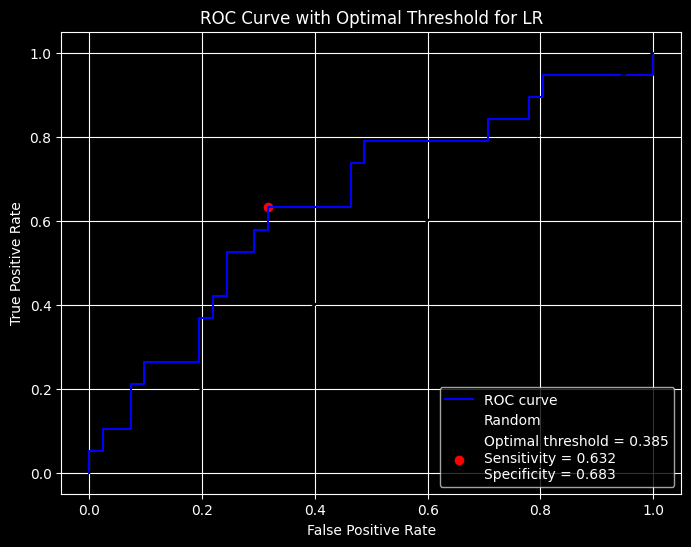

/opt/conda/lib/python3.9/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


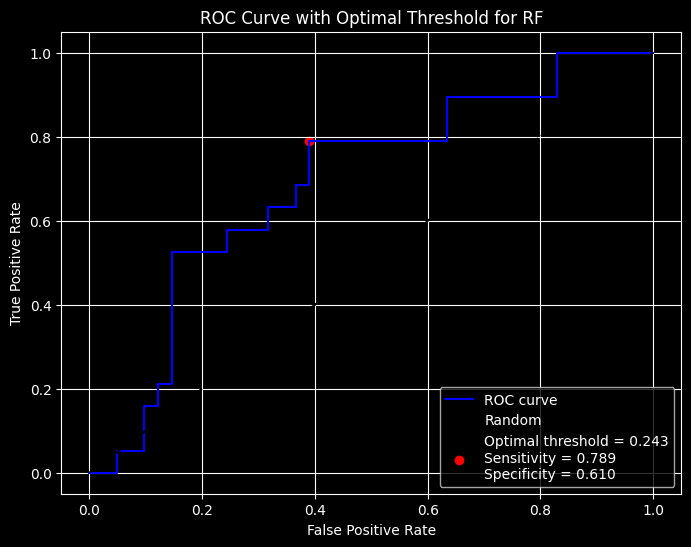

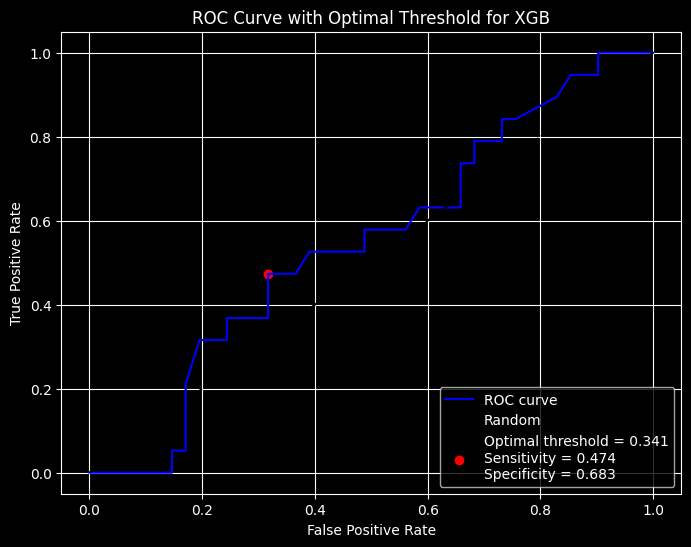

,model,optimal_threshold,youden_j,sensitivity,specificity
0,LR,0.384913,0.314506,0.631579,0.682927
1,RF,0.243186,0.399230,0.789474,0.609756
2,XGB,0.340629,0.156611,0.473684,0.682927


In [17]:
optimal_thresholds = {}
threshold_results = []
final_calibrated_models = {}

for row in picked_df.itertuples(index=False):
    feature_set = row.feature_set
    model_name = row.model
    if model_name == 'LogisticRegression':
        tag = 'LR'
    elif model_name == 'RandomForestClassifier':
        tag = 'RF'
    else:
        tag = 'XGB'
    
    calibrated_model = calibrated_models[tag]
    
    # Refit the underlying estimator on the best feature set (since the estimator was last fit on the final feature set)
    calibrated_model.estimator.fit(X_train[ladder[feature_set]], y_train)
    # Refit the calibrated model
    calibrated_model.fit(X_val[ladder[feature_set]], y_val)
    final_calibrated_models[tag] = calibrated_model
    
    # Save the final models
    filename = f"{tag}_{feature_set}.joblib"
    file_path = os.path.join('../models', filename)
    # Save the fully trained CalibratedClassifierCV object
    joblib.dump(calibrated_model, file_path)
    
    y_prob_cal = calibrated_model.predict_proba(X_test[ladder[feature_set]])[:, 1]
    full_metrics = find_optimal_threshold(y_test, y_prob_cal, tag)

    # We do not require the fpr, tpr and thresholds numpy arrays to display 
    desired_keys = ['model', 'optimal_threshold', 'youden_j', 'sensitivity', 'specificity']

    # Create a new dictionary containing only the desired keys
    selected_metrics = {k: full_metrics[k] for k in desired_keys}
    threshold_results.append(selected_metrics)
    
    # Store the optimal thresholds in a separate dictionary
    optimal_thresholds[tag] = threshold_results[-1]['optimal_threshold']

threshold_df = pd.DataFrame(threshold_results)
threshold_df.to_csv('../reports/tables/optimal_thresholds.csv')
display(threshold_df)

### 9.1. Threshold Analysis

The results from the threshold optimization (using Youden's J) on the **test set** are as follows:

**1. Logistic Regression (LR):**

The Logistic Regression model shows a moderate balance, placing it second in overall effectiveness.

   - **Optimal Threshold (0.385)**: A higher, more conservative cutoff than the RF model.

   - **Youden's J (Jmax​=0.315)**: The model is a stable performer, but its optimal balance is significantly lower than that of the RF model.

   - **Performance**: It achieves balanced scores, with Specificity (0.683) being slightly higher than its Sensitivity (0.632).

   - **Inference**: The LR model is the best choice when controlling False Positives (maximizing specificity) is marginally more important than maximizing the identification of positive cases.

**2. RandomForestClassifier (RF):**

The Random Forest model demonstrates the best overall balance and discriminative performance at its optimal operating point.

- **Optimal Threshold (0.243)**: This low threshold indicates the model is less confident and is optimized to avoid missing positive cases.

- **Youden's J (Jmax​=0.399)**: This is the highest J value, signifying the greatest vertical distance from the random line of chance.

- **Performance**: It achieves the highest Sensitivity (0.789) while maintaining a respectable Specificity (0.610).

- **Inference**: The RF model is the most effective discriminator of the group, prioritizing the identification of the positive class while keeping the False Positive Rate (FPR) relatively contained. This model provides the most robust platform for subsequent steps.

**3. XGBClassifier (XGB):**

The XGBoost model demonstrates the weakest discrimination, confirming its instability on this particular dataset.

- **Optimal Threshold (0.341)**: A median threshold value.

- **Youden's J (Jmax​=0.157)**: This value is the lowest, indicating the model's performance is barely better than a random guess.

- **Performance**: The model severely sacrifices Sensitivity (0.474) to achieve moderate Specificity (0.683). The Sensitivity is below 50%, meaning it fails to identify more than half of the true positive cases.

- **Inference**: The XGBoost model is unreliable and should be disregarded for deployment due to its high rate of False Negatives (low sensitivity).

# 10. Final Model Evaluation and Conclusion

We now generate the final classification reports for the three calibrated models using their respective optimal thresholds. This provides a complete, unbiased performance summary on the held-out **test set**, including both discrimination (ROC/PR-AUC) and calibration (Brier) metrics.

In [18]:
final_test_results = []

for row in picked_df.itertuples(index=False):
    model_name = row.model
    feature_set = row.feature_set
    
    if model_name == 'LogisticRegression': tag = 'LR'
    elif model_name == 'RandomForestClassifier': tag = 'RF'
    else: tag = 'XGB'

    est = final_calibrated_models[tag]
    threshold = optimal_thresholds[tag]
    feature_cols = ladder[feature_set]
    
    # Use the features the model was trained with
    y_prob_calibrated = est.predict_proba(X_test[feature_cols])[:, 1]
    
    # Convert probabilities to hard predictions (0 or 1)
    y_pred_hard = (y_prob_calibrated >= threshold).astype(int)
    
    final_evaluation_metrics = final_evaluation(y_test, y_prob_calibrated, y_pred_hard)
    
    # Information for current estimator
    result_row = {
    'model': model_name,
    'feature_set': feature_set,
    'threshold': threshold,
    }
    result_row.update(final_evaluation_metrics)
    final_test_results.append(result_row)
    
final_test_df = pd.DataFrame(final_test_results)
final_test_df.to_csv('../reports/tables/final_test_results.csv')
display(final_test_df.sort_values('pr_auc', ascending=False))

,model,feature_set,threshold,roc_auc,pr_auc,brier_score,accuracy,recall,precision,specificity,f1
0,LogisticRegression,ef,0.384913,0.648267,0.485399,0.205549,0.666667,0.631579,0.480000,0.682927,0.545455
1,RandomForestClassifier,ef+cr+na,0.243186,0.690629,0.459405,0.201512,0.666667,0.789474,0.483871,0.609756,0.600000
2,XGBClassifier,ef,0.340629,0.546855,0.345472,0.216430,0.616667,0.473684,0.409091,0.682927,0.439024


### 10.1. Final Inferences and Hypothesis Validation
These results constitute the final, unbiased evaluation of the models on the held-out test set, providing the definitive evidence regarding both predictive utility and the validation of the core hypotheses.

**1. Validation of Core Hypotheses:**

The results provide evidence that the primary hypotheses are valid and that the secondary hypotheses are invalid.

- **Dominant Predictors (ef and cr)**: The model with the highest performance (RandomForestClassifier) utilizes ef and implicitly cr (as it's used in the ef+cr+na set), confirming these as effective features. Furthermore, the simplest model tested (LogisticRegression on ef) achieved a respectable ROC AUC of 0.648. This supports the premise that ejection_fraction is a dominant, foundational predictor of mortality.

- **Independent Incremental Value (na and age2)**: The final results provide no evidence to support the hypothesis that serum sodium (na) or age nonlinearity (age2) offer significant independent incremental value.

**2. Model Selection and General Predictive Utility:**

The models demonstrate weak to moderate generalized discriminatory power, with no model achieving a robust ROC AUC above 0.70.

- **Best Performer (Random Forest)**: The RandomForestClassifier (using the ef+cr+na feature set) achieved the highest overall discriminatory performance (ROC AUC=0.691) and the best probability reliability (Brier Score=0.2015). This model is the most effective candidate for deployment, albeit with limited reliability.

- **Worst Performer (XGBoost)**: The XGBClassifier model (using the ef feature set) performed closest to random chance (ROC AUC=0.547), confirming its instability and unsuitability for prediction on this dataset.

- **Calibration**: All models achieved acceptable Brier Scores (near 0.20), confirming that the calibration step was successful in stabilizing the probability outputs.

### 10.2. Final Conclusion

The project partially validates the hypothesis by confirming that models built upon Ejection Fraction and Serum Creatinine are the most stable and discriminative. However, the models fail to conclusively prove the utility of the hypothesized incremental variables (serum_sodium and age_nonlinearity).